${\Huge \text{GroupFold Cross Validation - driver classification}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook aims to perform rigorous cross-validation by testing the model (fixed algorithm, fixed set of features) on mutations (or patients) that have never been seen in the training set, and then compare the performance differences with a basic cross-validation.

This notebook is divided in 4 parts:
* **1. Baseline**
* **2. GroupKFold with `group = mut_key`**
* **3. GroupKFold with `group = patient_key`**
* **4. Summary**

***

In [1]:
%run ../../../utils/Python/setup_environment.ipy
%run ../../../utils/Python/selene_job.ipy

Selene_Job.cluster_username             = 'guilminp'
Selene_Job.ssh_remote_jobs_cluster_path = '/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs'
Selene_Job.ssh_remote_jobs_local_path   = 'ssh_remote_jobs'

Setup environment... done!


<span style="color:green">✅ Working on **imp-ann_env** conda environment.</span>

# Baseline

In [2]:
data = Impact_Wrapper('../../../data/processed/annotated_final_IMPACT_mutations_20181105.txt', 'is_driver')

In [3]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
            'gene_type', 'VEP_SIFT_class', 'VEP_PolyPhen_class']

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (218173, 54) | y: (218173,)


,count_,freq_
False,140321,64.32%
True,77852,35.68%


In [4]:
job_baseline = Selene_Job('gkf_baseline')
job_baseline.load_data(X, y)

<span style="color:red">Job < gkf_baseline >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_baseline


<span style="color:green">Job < gkf_baseline >: </span>✅ data loaded

In [5]:
job_baseline = Selene_Job('gkf_baseline', load_from_id=True)

<span style="color:green">Job < gkf_baseline >: </span>✅ job found and reloaded

In [6]:
%%writefile {job_baseline.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# set cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=18, criterion='entropy'))
metrics = Metrics(model, X, y, cv_strategy, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_gkf_baseline/script.ipy


In [7]:
job_baseline.run(n_jobs=25, short_job=True)

➞ scp ssh_remote_jobs/job_gkf_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_baseline
script.ipy                                    100%  861     1.2KB/s   00:00    
X.pkl                                         100%   53MB  13.9MB/s   00:03    
y.pkl                                         100% 3623KB  10.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_baseline
Job <31416188> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_baseline -We 59 -n 25 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < gkf_baseline >: </span>✅ submitted<br>

In [8]:
job_baseline.get_results()

<span style="color:red">Job < gkf_baseline >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.505 ± 0.015
▴ Mean roc_auc          : 0.888 ± 0.005
▴ Mean precision        : 0.164 ± 0.004
▴ Mean recall           : 0.739 ± 0.013
▴ Mean f1               : 0.269 ± 0.006
▴ Mean accuracy         : 0.878 ± 0.003


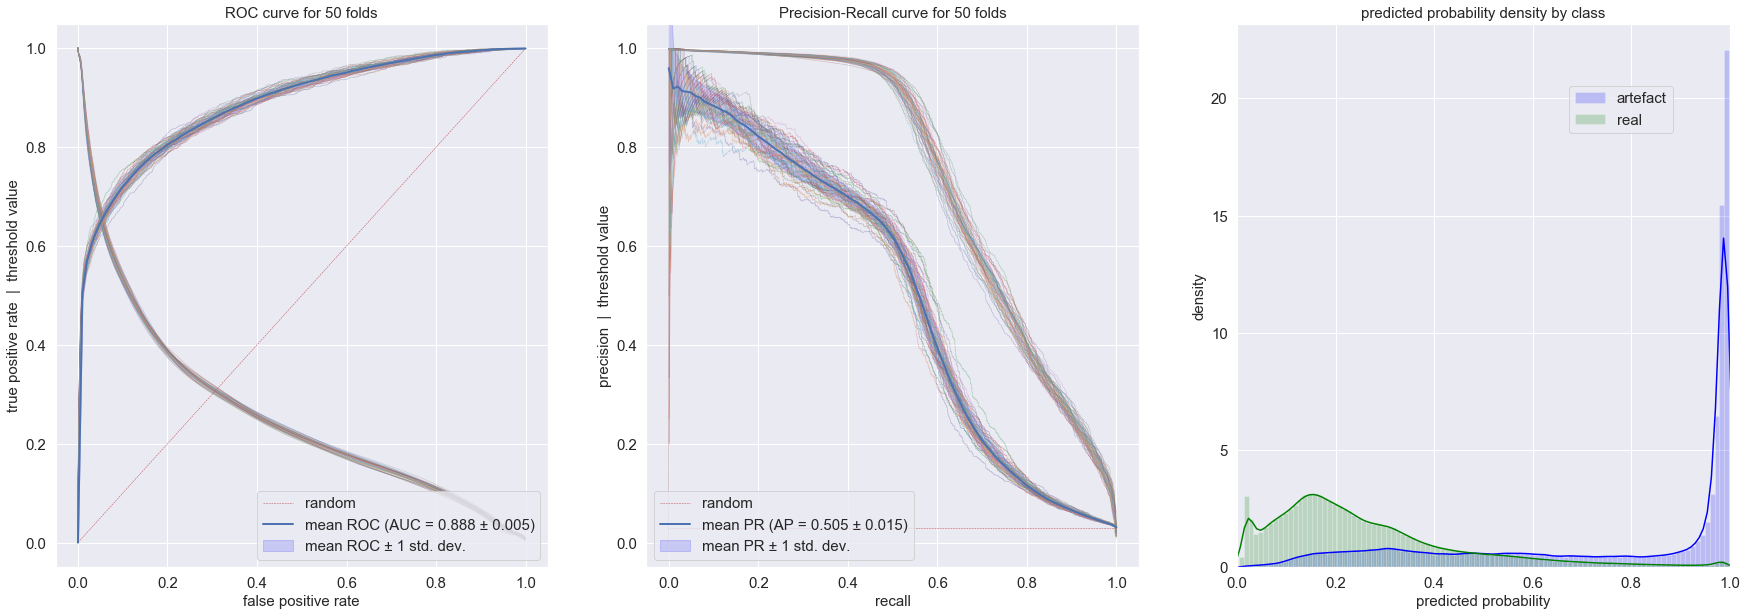

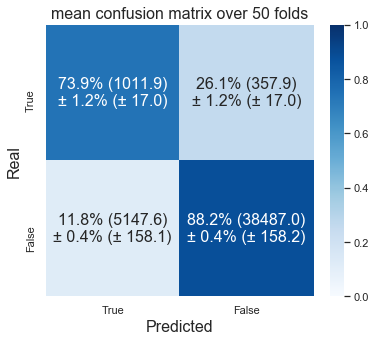

In [4]:
job_baseline.metrics.print_mean()
job_baseline.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_baseline.metrics.plot_mean_confusion_matrix()

# GroupKFold with group = `mut_key`

In [9]:
group_mut_key = data.get_original_impact()['mut_key']

In [10]:
job_mut_key = Selene_Job('gkf_mut_key')
job_mut_key.load_data(X, y, groups=group_mut_key)

➞ mkdir on local computer ssh_remote_jobs/job_gkf_mut_key


<span style="color:green">Job < gkf_mut_key >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_mut_key
➞ save groups.pkl in ssh_remote_jobs/job_gkf_mut_key


<span style="color:green">Job < gkf_mut_key >: </span>✅ data loaded

In [11]:
job_mut_key = Selene_Job('gkf_mut_key', load_from_id=True)

<span style="color:green">Job < gkf_mut_key >: </span>✅ job found and reloaded

In [12]:
%%writefile {job_mut_key.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
groups = pd.read_pickle('groups.pkl')

# set cross-validation
from sklearn.model_selection import GroupKFold
cv_strategy = GroupKFold(n_splits=5)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=18, criterion='entropy'))
metrics = Metrics(model, X, y, cv_strategy, groups=groups, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_gkf_mut_key/script.ipy


In [13]:
job_mut_key.run(n_jobs=25, short_job=True)

➞ scp ssh_remote_jobs/job_gkf_mut_key to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_mut_key
groups.pkl                                    100% 6556KB  14.6MB/s   00:00    
script.ipy                                    100%  857    74.4KB/s   00:00    
X.pkl                                         100%   53MB  17.8MB/s   00:03    
y.pkl                                         100% 3623KB  17.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_mut_key
Job <31416200> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_mut_key -We 59 -n 25 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < gkf_mut_key >: </span>✅ submitted<br>

In [14]:
job_mut_key.get_results()

<span style="color:red">Job < gkf_mut_key >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.496 ± 0.029
▴ Mean roc_auc          : 0.882 ± 0.009
▴ Mean precision        : 0.162 ± 0.011
▴ Mean recall           : 0.734 ± 0.017
▴ Mean f1               : 0.266 ± 0.016
▴ Mean accuracy         : 0.877 ± 0.008


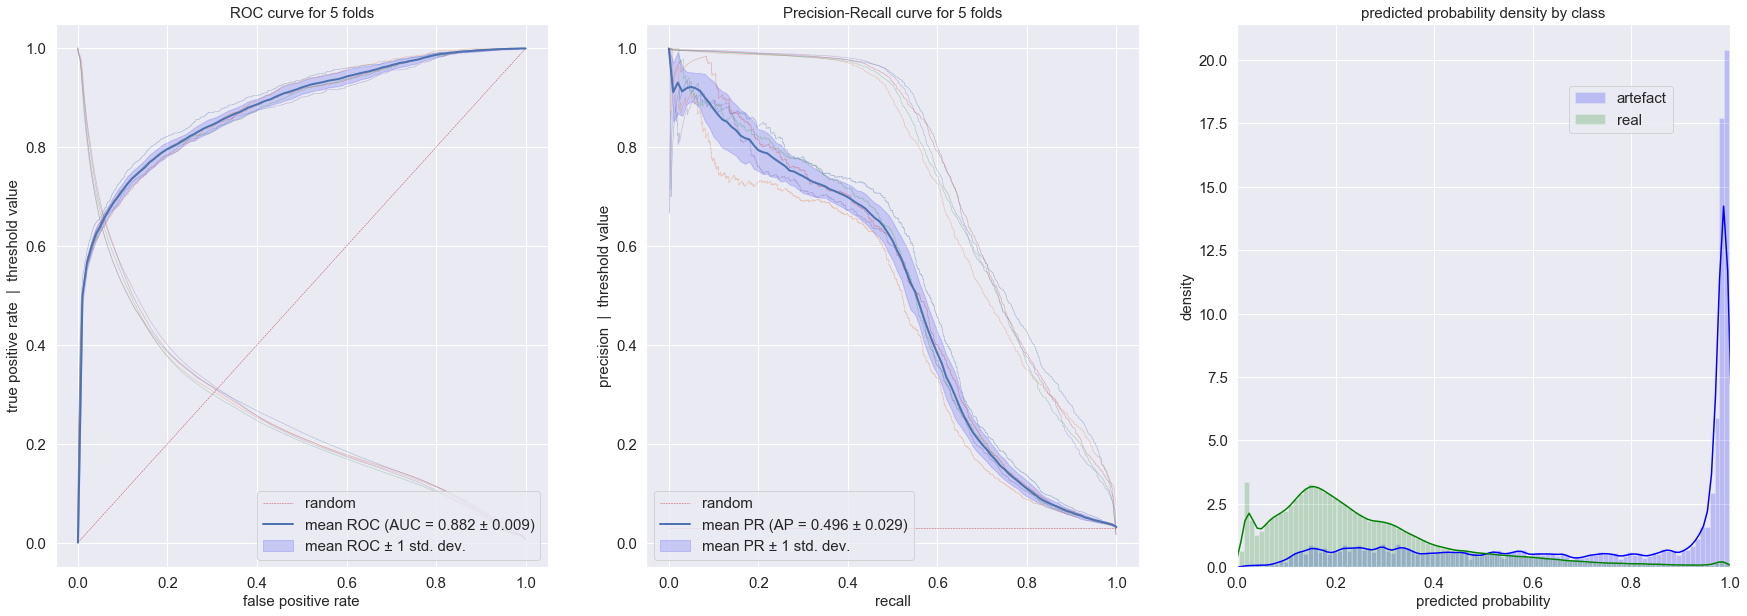

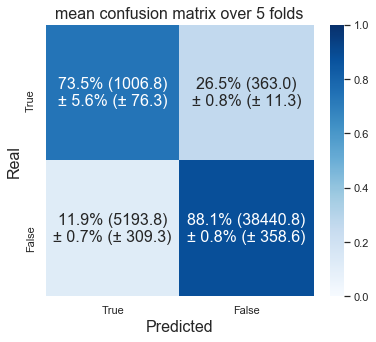

In [7]:
job_mut_key.metrics.print_mean()
job_mut_key.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_mut_key.metrics.plot_mean_confusion_matrix()

# GroupKFold with group = `patient_key`

In [15]:
group_patient_key = data.get_original_impact()['patient_key']

In [16]:
job_patient_key = Selene_Job('gkf_patient_key')
job_patient_key.load_data(X, y, groups=group_patient_key)

➞ mkdir on local computer ssh_remote_jobs/job_gkf_patient_key


<span style="color:green">Job < gkf_patient_key >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_patient_key
➞ save groups.pkl in ssh_remote_jobs/job_gkf_patient_key


<span style="color:green">Job < gkf_patient_key >: </span>✅ data loaded

In [17]:
job_patient_key = Selene_Job('gkf_patient_key', load_from_id=True)

<span style="color:green">Job < gkf_patient_key >: </span>✅ job found and reloaded

In [18]:
%%writefile {job_patient_key.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
groups = pd.read_pickle('groups.pkl')

# set cross-validation
from sklearn.model_selection import GroupKFold
cv_strategy = GroupKFold(n_splits=5)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=18, criterion='entropy'))
metrics = Metrics(model, X, y, cv_strategy, groups=groups, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_gkf_patient_key/script.ipy


In [19]:
job_patient_key.run(n_jobs=25, short_job=True)

➞ scp ssh_remote_jobs/job_gkf_patient_key to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_patient_key
groups.pkl                                    100% 4609KB  11.9MB/s   00:00    
script.ipy                                    100%  857   113.1KB/s   00:00    
X.pkl                                         100%   53MB  14.4MB/s   00:03    
y.pkl                                         100% 3623KB  14.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_gkf_patient_key
Job <31416244> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_patient_key -We 59 -n 25 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < gkf_patient_key >: </span>✅ submitted<br>

In [20]:
job_patient_key.get_results()

<span style="color:red">Job < gkf_patient_key >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

▴ Mean average_precision: 0.490 ± 0.037
▴ Mean roc_auc          : 0.873 ± 0.014
▴ Mean precision        : 0.160 ± 0.008
▴ Mean recall           : 0.710 ± 0.042
▴ Mean f1               : 0.260 ± 0.010
▴ Mean accuracy         : 0.877 ± 0.008


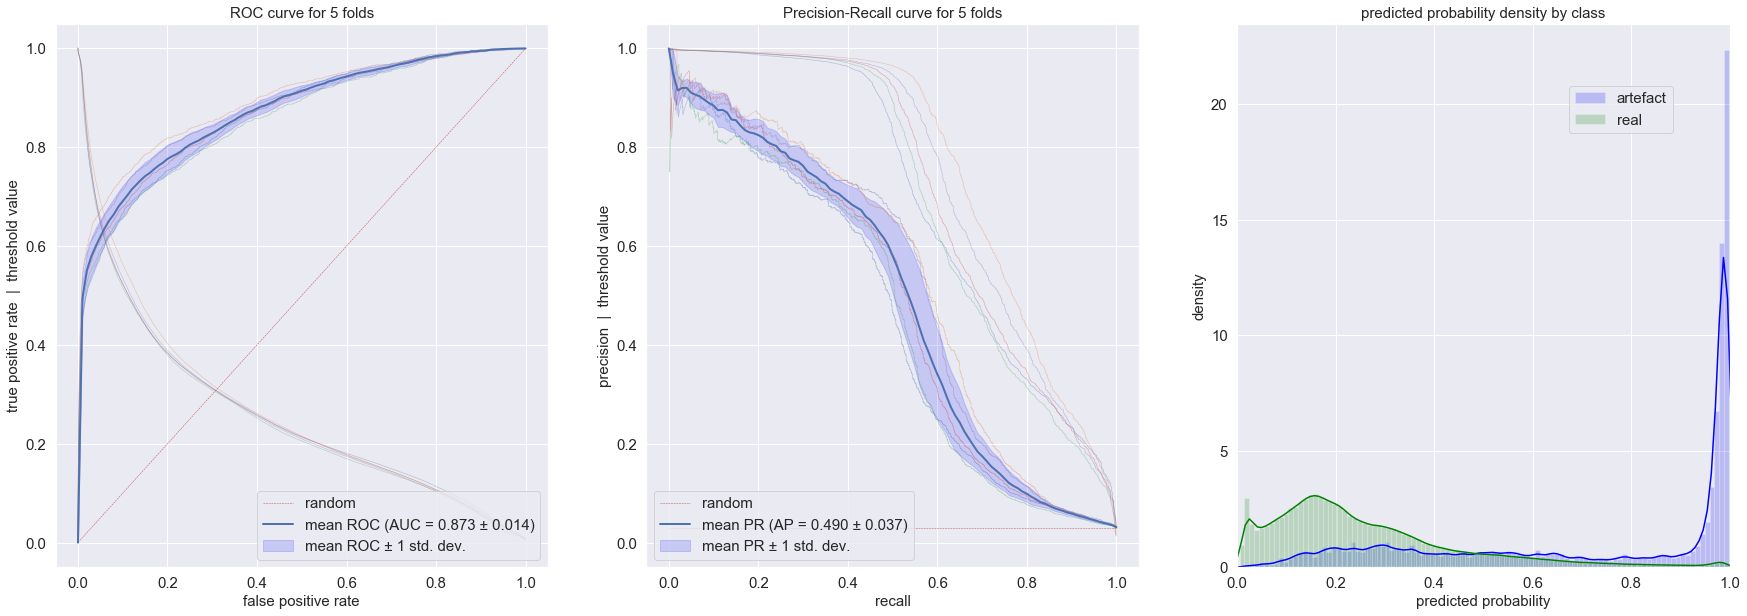

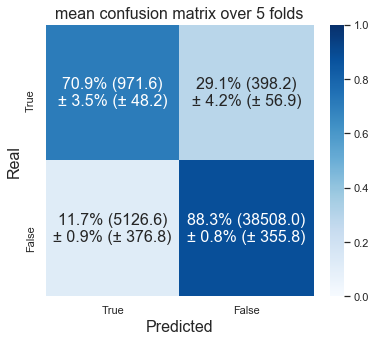

In [10]:
job_patient_key.metrics.print_mean()
job_patient_key.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_patient_key.metrics.plot_mean_confusion_matrix()

# Summary

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.505,0.888,0.164,0.739,0.269,0.878
mut_key,0.496,0.882,0.162,0.734,0.266,0.877
patient_key,0.49,0.873,0.16,0.71,0.26,0.877


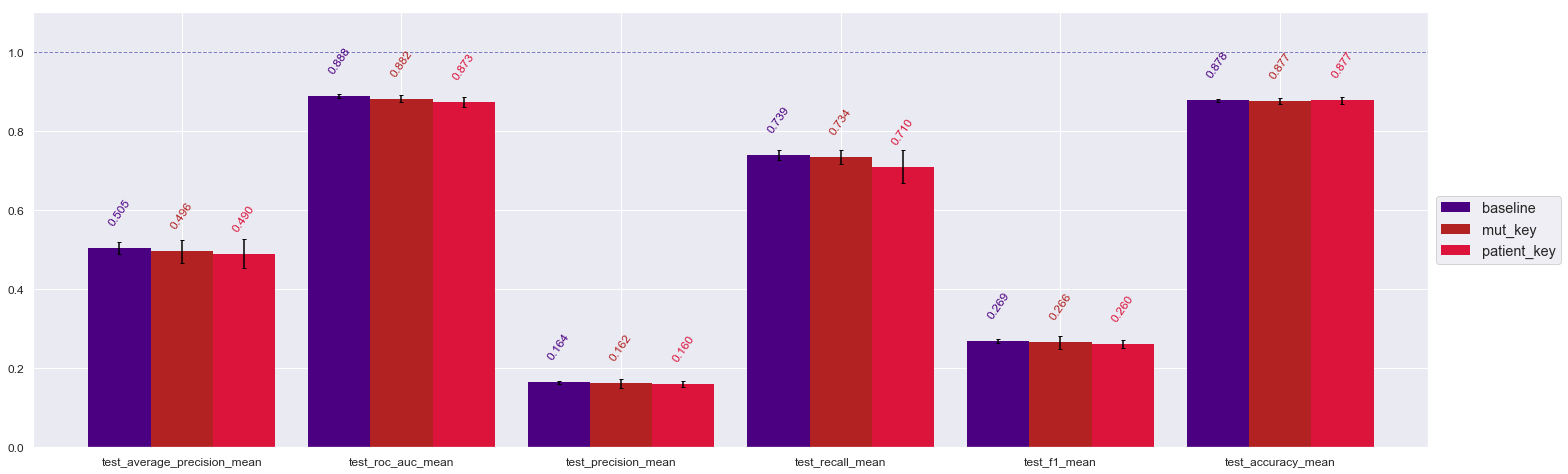

In [12]:
summary = Summary()
summary.add(job_baseline.metrics   , 'baseline'   , 'indigo')
summary.add(job_mut_key.metrics    , 'mut_key'    , 'firebrick')
summary.add(job_patient_key.metrics, 'patient_key', 'crimson')
summary.display()
summary.plot()